In [1]:
import pandas as pd

In [23]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
message = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
message.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
message.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
message['length'] = message['message'].apply(len)
message.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


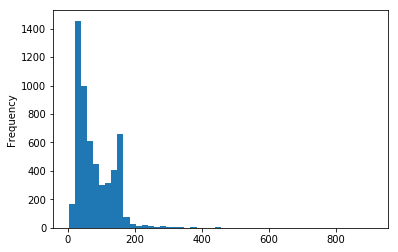

In [7]:
message['length'].plot(bins=50, kind='hist') 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f922d1151d0>,
      dtype=object)

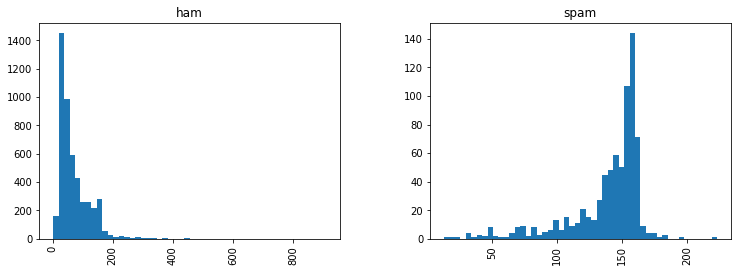

In [8]:
message.hist(column='length', by='label', bins=50,figsize=(12,4))

In [17]:
import string

In [9]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [11]:
message.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [24]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(message['message'])

In [25]:
print(len(bow_transformer.vocabulary_))

11425


10